<h1> DATA CLEANING </h1>

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

%matplotlib inline

In [57]:
df = pd.read_csv("./clean_data.csv")
df = df.rename(columns={"Unnamed: 0": "index"})
df = df.set_index("index")

In [58]:
for column in df.columns.to_list():
    df[column] = df[column].apply(lambda x:int(eval(x)) if x in ['True', 'False'] else x)
    df[column] = df[column].apply(lambda x:int(x) if x in [True, False] else x)


df.drop(df[df.subtype == 'APARTMENT_BLOCK'].index, axis=0, inplace=True)
df.drop(['terraceSurface', 'gardenSurface', "isFurnished", 'facadeCount'], axis=1, inplace=True)

df.loc[df.kitchen.isin(['USA_SEMI_EQUIPPED', 'USA_UNINSTALLED']), 'kitchen'] = 0
df.rename(columns={'kitchen':'full_kitchen'}, inplace=True)

features = ['type', 'subtype', 'price', 'postalCode', 'condition', 'bedroomCount', 'netHabitableSurface']
df.drop_duplicates(subset=features, inplace=True)

df.dropna(subset=['price'], inplace=True)
df.dropna(subset=['netHabitableSurface'], inplace=True)
# df.dropna(subset=['condition'], inplace=True)
df.dropna(subset=['full_kitchen'], inplace=True)

for column in ['hasTerrace','hasGarden', 'full_kitchen', 'hasSwimmingPool']:
    df[column].fillna(0, inplace=True)
df = df.astype({'hasTerrace': int, 'hasGarden': int, 'full_kitchen': int})

type_binary = {'HOUSE': 1,
               'APARTMENT': 0}

df.type = df.type.apply(lambda x:type_binary[x])


In [59]:
codes = (("Brussels Capital Region", 1000, 1299),
          ("Walloon Brabant", 1300, 1499),
          ("Flemish Brabant", 1500, 1999),
          ("Antwerp", 2000, 2999),
          ("Flemish Brabant", 3000, 3499),
          ("Limburg", 3500, 3999),
          ("Liege", 4000, 4999),
          ("Namur", 5000, 5999),
          ("Hainaut", 6000, 6599),
          ("Luxembourg", 6600, 6999),
          ("Hainaut", 7000, 7999),
          ("West Flanders", 8000, 8999),
          ("East Flanders", 9000, 9999))

def find_province(postalCode):
    for _tuple in codes:
        if _tuple[1] <= postalCode <= _tuple[2]:
            return _tuple[0]
    return np.nan

# province = df.postalCode.apply(find_province)
# df['Province'] = province

## Machine Learning

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

In [61]:
s = df.postalCode
codes = pd.get_dummies(s, drop_first=True)
df.drop(['postalCode', 'locality'], axis=1, inplace=True)
codes.shape

(10016, 856)

In [62]:
s = df.subtype
subtypes = pd.get_dummies(s, drop_first=True)
df.drop(['subtype'], axis=1, inplace=True)
subtypes.shape

(10016, 21)

In [63]:
belgium = pd.concat([df, codes, subtypes], axis=1)

# Not using the 'condition' ordinal feature for now
belgium.drop(['condition'], axis=1, inplace=True)

In [64]:
belgium = belgium[(np.abs(stats.zscore(belgium['price'])) < 3)]
#belgium = belgium[(np.abs(stats.zscore(belgium['bedroomCount'])) < 3)]

# Getting rid of persisting outliers at low-values
belgium = belgium.sort_values('price').iloc[9:,:]

price = np.array(belgium.price)
data = belgium.drop('price', axis=1)

In [65]:
print(len(belgium))
belgium.sort_values('price').head(10)

9846


,type,price,bedroomCount,netHabitableSurface,full_kitchen,hasTerrace,hasGarden,hasSwimmingPool,fireplaceExists,1020,...,LOFT,MANOR_HOUSE,MANSION,MIXED_USE_BUILDING,OTHER_PROPERTY,PENTHOUSE,SERVICE_FLAT,TOWN_HOUSE,TRIPLEX,VILLA
index,,,,,,,,,,,,,,,,,,,,,
486,1,36000.0,1.0,25.0,0,1,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4534,1,38000.0,3.0,191.0,0,1,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
7665,1,39000.0,2.0,47.0,0,1,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
8930,1,40000.0,3.0,199.0,0,1,0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
17847,0,40000.0,1.0,24.0,0,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3917,1,40000.0,2.0,155.0,0,0,0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,1
2475,1,45000.0,1.0,70.0,0,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
12287,0,45000.0,1.0,43.0,1,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5599,1,47500.0,1.0,70.0,1,0,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
y_box = np.ravel(power_transform(price.reshape(-1, 1), method='box-cox'))
y = price
y_log = np.log(price)
X = data
X.head()

,type,bedroomCount,netHabitableSurface,full_kitchen,hasTerrace,hasGarden,hasSwimmingPool,fireplaceExists,1020,1030,...,LOFT,MANOR_HOUSE,MANSION,MIXED_USE_BUILDING,OTHER_PROPERTY,PENTHOUSE,SERVICE_FLAT,TOWN_HOUSE,TRIPLEX,VILLA
index,,,,,,,,,,,,,,,,,,,,,
486,1,1.0,25.0,0,1,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4534,1,3.0,191.0,0,1,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7665,1,2.0,47.0,0,1,1,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8930,1,3.0,199.0,0,1,0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17847,0,1.0,24.0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
scaler = RobustScaler()

In [68]:
model = RandomForestRegressor(random_state=0)

In [69]:
Kfolds = RepeatedKFold(n_splits=5, n_repeats=1, random_state=21)

In [70]:
def my_pipe(scaler, model, Kfolds, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    params_en = {
        'min_samples_split' : [4, 5, 6],
        'max_features' : ['log2']
    }

    results = GridSearchCV(model, param_grid=params_en, cv=Kfolds, scoring='r2', n_jobs=-1, verbose=1).fit(X_train, y_train)
    y_predict = results.predict(X_test)

    print(results.best_score_, results.best_params_)
    print(r2_score(y_test, y_predict))

    sns.residplot(x=y_test, y=y_predict)
    
    return None

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.6476258703306594 {'max_features': 'log2', 'min_samples_split': 4}
0.6408325962350658


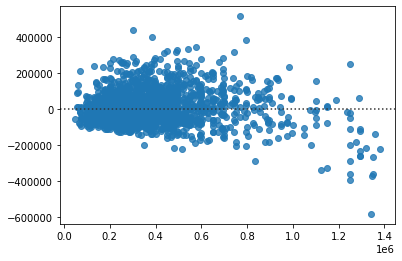

In [71]:
my_pipe(scaler, model, Kfolds, X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.6552470539541193 {'max_features': 'log2', 'min_samples_split': 5}
0.6741141894429795


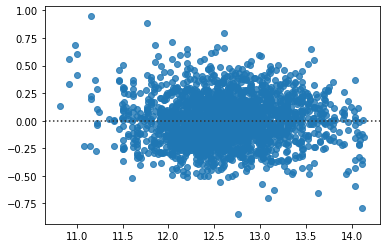

In [72]:
my_pipe(scaler, model, Kfolds, X, y_log)

As we can see, training the RandomForestRegressor on the target leads to a residual plot with a noticeable heteroscedasticity; using the log of the target removes the increasing correlated variance, and improves the r2 score. The score is still quite low, but that is probably due to either: 
1) Issues during the scraping (some values were not properly gathered and the dataset is not good enough)
2) Issues in the cleaning (either too many rows or features were dropped, or some inferences for value replacement were not valid)
3) Issues stemming from features interacting with one another (bedroomCount and netHabitableSurface for instance).